In [1]:
import time

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    auc,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
from xgboost import XGBClassifier
import matplotlib

In [2]:
%matplotlib inline

In [3]:
def sort_importances(importances, columns):
    normalized_importances = importances / importances.sum()
    indexes = np.argsort(-importances)
    sorted_importance = normalized_importances[indexes]

    return sorted_importance, columns[indexes].tolist()

def feature_selection(result_line):

    total_imp = 0
    important_columns = []
    i = 0
    while (
        total_imp < 0.95
        and i < len(result_line.features)
        and result_line.feature_importances[i] > 0.002
    ):
        total_imp += result_line.feature_importances[i]
        important_columns.append(result_line.features[i])
        i += 1

    return important_columns


def train_xgb(
    X_train,
    Y_train,
    X_valid,
    Y_valid,
    X_test,
    Y_test,
    A_valid,
    A_test,
    name,
    sample_weight_train=None,
    sample_weight_valid=None,
):
    print(
        f"Training model with {X_train.shape[1]} features, on {X_train.shape[0]} rows (valid {X_valid.shape[0]} rows, test {X_test.shape[0]} rows) "
    )
    start = time.time()
    xgb_params = {
        "seed": 7,
        "objective": "binary:logistic",
        "n_estimators": 1000,
        "max_depth": 3,
        "importance_type": "gain",
        "use_label_encoder": False,
    }
    model = XGBClassifier(**xgb_params)

    weights = {}

    if sample_weight_train is not None:
        weights["sample_weight"] = sample_weight_train
        weights["sample_weight_eval_set"] = [sample_weight_train, sample_weight_valid]

    model.fit(
        X_train,
        Y_train,
        eval_metric="auc",
        early_stopping_rounds=20,
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
        verbose=False,
        **weights,
    )

    end = time.time()

    sorted_imps, sorted_cols = sort_importances(
        model.feature_importances_, X_train.columns
    )

    pred_valid = model.predict_proba(X_valid)[:, 1]
    pred_test = model.predict_proba(X_test)[:, 1]

    precision_valid, recall_valid, _ = precision_recall_curve(Y_valid, pred_valid)
    precision_test, recall_test, _ = precision_recall_curve(Y_test, pred_test)

    to_ret = pd.DataFrame(
        [
            {
                "name": name,
                "auc_valid": roc_auc_score(
                    Y_valid.values.reshape(-1),
                    pred_valid,
                ),
                "pr_auc_valid": auc(recall_valid, precision_valid),
                "auc_test": roc_auc_score(
                    Y_test.values.reshape(-1),
                    pred_test,
                ),
                "pr_auc_test": auc(recall_test, precision_test),
                "nb_features": X_train.shape[1],
                "model": model,
                "feature_importances": sorted_imps,
                "sorted_features": sorted_cols,
                "features": X_train.columns.tolist(),
                "precision_recall_valid": [precision_valid, recall_valid],
                "roc_curve_valid": roc_curve(Y_valid, pred_valid)[:2],
                "precision_recall_test": [precision_test, recall_test],
                "roc_curve_test": roc_curve(Y_test, pred_test)[:2],
            }
        ]
    )

    metrics = time.time()
    print(
        "Training took: {:.4f} seconds, metrics took {:.4f} seconds".format(
            end - start, metrics - end
        )
    )

    print(
        "ROC AUC valid: {:.4f} ROC AUC test: {:.4f}".format(
            to_ret.auc_valid.iloc[0], to_ret.auc_valid.iloc[0]
        )
    )
    print(
        "PR AUC valid: {:.4f} PR AUC test: {:.4f}".format(
            to_ret.pr_auc_valid.iloc[0], to_ret.pr_auc_test.iloc[0]
        )
    )
    print()
    return to_ret


In [4]:
import matplotlib.pyplot as plt

from sklearn.metrics import auc


# plot no skill and model precision-recall curves
def plot_curves(precision, recall, fpr, tpr, y):

    # calculate the precision-recall auc
    # precision, recall, _ = precision_recall_curve(y_test, model_probs)
    # fpr, tpr, _ = roc_curve(y_test, model_probs)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y == 1]) / len(y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle="--", label="No Skill PR AUC")
    plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill ROC AUC")

    # plot model precision-recall curve
    plt.plot(recall, precision, marker=".", label=f"PR AUC ({pr_auc})")
    plt.plot(fpr, tpr, marker=".", label=f"ROC AUC ({roc_auc})")
    # axis labels
    plt.xlabel("Recall/TPR")
    plt.ylabel("Precision/FPR")
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

def save_plot(name):
    plt.savefig(name)
    plt.clf()

def plot_valid_test(result, y_valid, y_test, name=None):
    plot_curves(
        result["precision_recall_valid"][0],
        result["precision_recall_valid"][1],
        result["roc_curve_valid"][0],
        result["roc_curve_valid"][1],
        y_valid,
    )
    if name is not None:
        save_plot(name + "_valid.png")

    plot_curves(
        result["precision_recall_test"][0],
        result["precision_recall_test"][1],
        result["roc_curve_test"][0],
        result["roc_curve_test"][1],
        y_test,
    )
    if name is not None:
        save_plot(name + "_test.png")


def print_metrics(metric_frame, name=None):
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[-1, 1],
        legend=False,
        figsize=[12, 24],
        title="Accuracy and selection rate by group",
    )
    if name is not None:
        save_plot(name + ".png")

    print()
    print("Overall fairness metrics")
    print(metric_frame.overall)
    print()
    print("By group fairness metrics")
    print(metric_frame.by_group)
    print()

def plot_models(all_results, name=None):
    x = all_results.auc_valid.tolist()
    y = all_results.diff_selection_rate.tolist()
    keys = all_results.name.tolist()

    plt.scatter(x, y)
    for i in range(len(x)):
        plt.annotate(keys[i], (x[i], y[i] + 0.001))
    plt.xlabel("ROC AUC")
    plt.ylabel("Selection rate difference")
    if name is not None:
        save_plot(name + ".png")


In [5]:
X, Y = fetch_openml(data_id=1590, as_frame=True, return_X_y=True)
Y = (Y == ">50K") * 1
sensitives_features = ["sex"]  # "sex",
seed = 7
test_size = 0.2
valid_size = 0.2

/test_proj/.venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
A = X[sensitives_features]
X = X.drop(columns=sensitives_features)

In [7]:
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,0.0,0.0,30.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,0.0,0.0,38.0,United-States
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,0.0,0.0,40.0,United-States
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,0.0,0.0,40.0,United-States
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,0.0,0.0,20.0,United-States


In [8]:
X = pd.get_dummies(X)
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25.0,226802.0,7.0,0.0,0.0,40.0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,257302.0,12.0,0.0,0.0,38.0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48838,40.0,154374.0,9.0,0.0,0.0,40.0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48839,58.0,151910.0,9.0,0.0,0.0,40.0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48840,22.0,201490.0,9.0,0.0,0.0,20.0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [9]:
X_model, X_test, Y_model, Y_test, A_model, A_test = train_test_split(
    X, Y, A, test_size=test_size, random_state=seed, stratify=Y
)

In [10]:
X_train, X_valid, Y_train, Y_valid, A_train, A_valid = train_test_split(
    X_model, Y_model, A_model, test_size=valid_size, random_state=seed, stratify=Y_model
)

In [11]:
results = train_xgb(
    X_train,
    Y_train,
    X_valid,
    Y_valid,
    X_test,
    Y_test,
    A_valid,
    A_test,
    "Unmitigated Model with all features",
)
results["original"] = True
results

Training model with 103 features, on 31258 rows (valid 7815 rows, test 9769 rows) 


/test_proj/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/test_proj/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/test_proj/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training took: 5.5086 seconds, metrics took 0.0409 seconds
ROC AUC valid: 0.9272 ROC AUC test: 0.9272
PR AUC valid: 0.8283 PR AUC test: 0.8305



,name,auc_valid,pr_auc_valid,auc_test,pr_auc_test,nb_features,model,feature_importances,sorted_features,features,precision_recall_valid,roc_curve_valid,precision_recall_test,roc_curve_test,original
0,Unmitigated Model with all features,0.92716,0.828276,0.928812,0.830524,103,"XGBClassifier(base_score=None, booster=None, c...","[0.47343054, 0.07285538, 0.037532415, 0.035370...","[marital-status_Married-civ-spouse, education-...","[age, fnlwgt, education-num, capital-gain, cap...","[[0.23928342930262317, 0.2393140517020732, 0.2...","([0.0, 0.0, 0.0, 0.0001682085786375105, 0.0001...","[[0.23932848807452145, 0.23935298935298935, 0....","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True


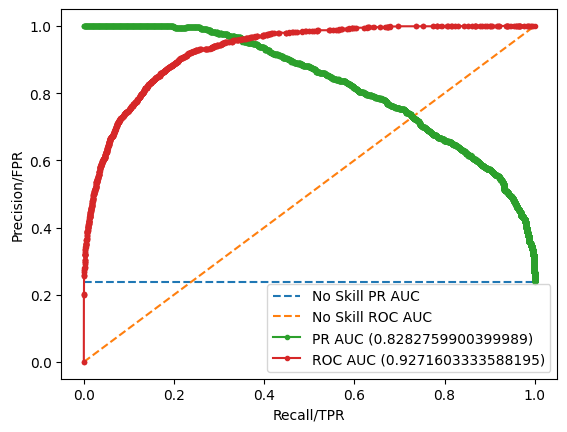

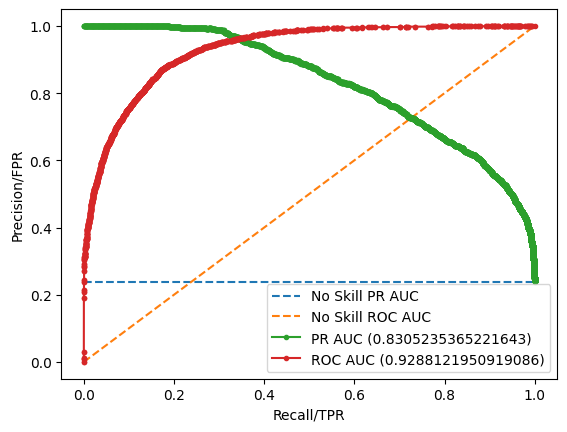

In [12]:
plot_valid_test(results.iloc[-1], Y_valid, Y_test)

In [13]:
important_columns = feature_selection(results.iloc[0])
important_columns

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'education_10th',
 'education_11th',
 'education_12th',
 'education_1st-4th',
 'education_5th-6th',
 'education_7th-8th',
 'education_9th',
 'education_Assoc-acdm',
 'education_Assoc-voc',
 'education_Bachelors',
 'education_Doctorate',
 'education_HS-grad',
 'education_Masters',
 'education_Preschool',
 'education_Prof-school',
 'education_Some-college',
 'marital-status_Divorced',
 'marital-status_Married-AF-spouse',
 'marital-status_Married-civ-spouse',
 'marital-status_Married-spouse-absent',
 'marital-status_Never-married',
 'marital-status_Separated',
 'marital-status_Widowed',
 'occupation_Adm-clerical',
 'occupation_Armed-Forces',
 'occupation_Craft-repair',
 'occupation_Exec-manageria

In [14]:
results = results.append(
    train_xgb(
        X_train[important_columns],
        Y_train,
        X_valid[important_columns],
        Y_valid,
        X_test[important_columns],
        Y_test,
        A_valid,
        A_test,
        "Unmitigated Model with only selected features",
    )
).reset_index(drop=True)
results

Training model with 47 features, on 31258 rows (valid 7815 rows, test 9769 rows) 


/test_proj/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/test_proj/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/test_proj/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training took: 2.4646 seconds, metrics took 0.0315 seconds
ROC AUC valid: 0.9243 ROC AUC test: 0.9243
PR AUC valid: 0.8234 PR AUC test: 0.8290



/tmp/ipykernel_428/2804951922.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


,name,auc_valid,pr_auc_valid,auc_test,pr_auc_test,nb_features,model,feature_importances,sorted_features,features,precision_recall_valid,roc_curve_valid,precision_recall_test,roc_curve_test,original
0,Unmitigated Model with all features,0.927160,0.828276,0.928812,0.830524,103,"XGBClassifier(base_score=None, booster=None, c...","[0.47343054, 0.07285538, 0.037532415, 0.035370...","[marital-status_Married-civ-spouse, education-...","[age, fnlwgt, education-num, capital-gain, cap...","[[0.23928342930262317, 0.2393140517020732, 0.2...","([0.0, 0.0, 0.0, 0.0001682085786375105, 0.0001...","[[0.23932848807452145, 0.23935298935298935, 0....","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
1,Unmitigated Model with only selected features,0.924347,0.823350,0.927225,0.828986,47,"XGBClassifier(base_score=None, booster=None, c...","[0.41489798, 0.11703618, 0.08458461, 0.0504857...","[marital-status_Married-civ-spouse, education-...","[age, fnlwgt, education-num, capital-gain, cap...","[[0.23928342930262317, 0.2393140517020732, 0.2...","([0.0, 0.0, 0.0, 0.0001682085786375105, 0.0001...","[[0.23932848807452145, 0.23935298935298935, 0....","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001345...",NaN


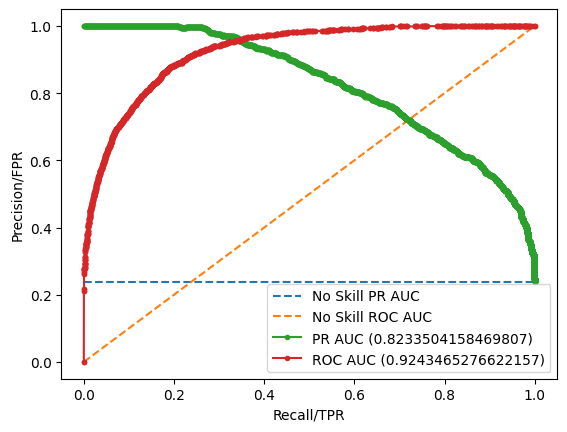

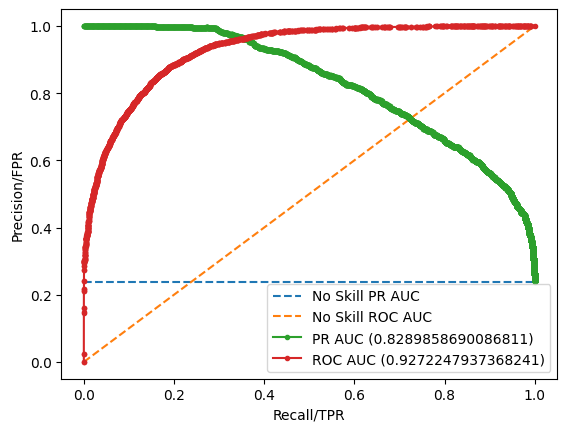

In [15]:
plot_valid_test(results.iloc[-1], Y_valid, Y_test)

In [16]:
results = results.append(
    train_xgb(
        X_train[important_columns[:5]],
        Y_train,
        X_valid[important_columns[:5]],
        Y_valid,
        X_test[important_columns[:5]],
        Y_test,
        A_valid,
        A_test,
        "Unmitigated Model with only 5 selected features",
    )
).reset_index(drop=True)
results

Training model with 5 features, on 31258 rows (valid 7815 rows, test 9769 rows) 


/test_proj/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/test_proj/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/test_proj/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training took: 2.0227 seconds, metrics took 0.0383 seconds
ROC AUC valid: 0.8596 ROC AUC test: 0.8596
PR AUC valid: 0.7258 PR AUC test: 0.7316



/tmp/ipykernel_428/4132205175.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


,name,auc_valid,pr_auc_valid,auc_test,pr_auc_test,nb_features,model,feature_importances,sorted_features,features,precision_recall_valid,roc_curve_valid,precision_recall_test,roc_curve_test,original
0,Unmitigated Model with all features,0.927160,0.828276,0.928812,0.830524,103,"XGBClassifier(base_score=None, booster=None, c...","[0.47343054, 0.07285538, 0.037532415, 0.035370...","[marital-status_Married-civ-spouse, education-...","[age, fnlwgt, education-num, capital-gain, cap...","[[0.23928342930262317, 0.2393140517020732, 0.2...","([0.0, 0.0, 0.0, 0.0001682085786375105, 0.0001...","[[0.23932848807452145, 0.23935298935298935, 0....","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
1,Unmitigated Model with only selected features,0.924347,0.823350,0.927225,0.828986,47,"XGBClassifier(base_score=None, booster=None, c...","[0.41489798, 0.11703618, 0.08458461, 0.0504857...","[marital-status_Married-civ-spouse, education-...","[age, fnlwgt, education-num, capital-gain, cap...","[[0.23928342930262317, 0.2393140517020732, 0.2...","([0.0, 0.0, 0.0, 0.0001682085786375105, 0.0001...","[[0.23932848807452145, 0.23935298935298935, 0....","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001345...",NaN
2,Unmitigated Model with only 5 selected features,0.859650,0.725788,0.864323,0.731572,5,"XGBClassifier(base_score=None, booster=None, c...","[0.46331647, 0.22772653, 0.1942774, 0.09572719...","[education-num, capital-gain, age, capital-los...","[age, fnlwgt, education-num, capital-gain, cap...","[[0.23928342930262317, 0.2393140517020732, 0.2...","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.23932848807452145, 0.23935298935298935, 0....","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN


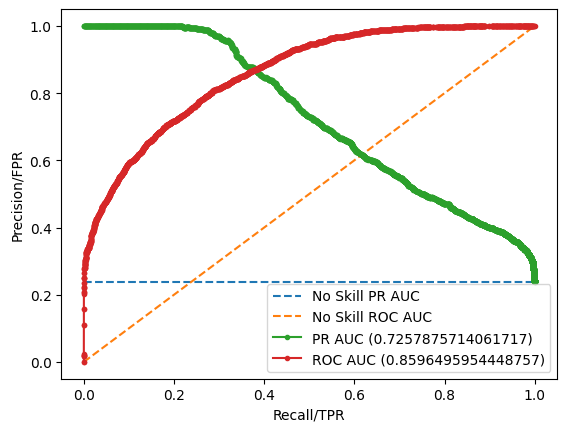

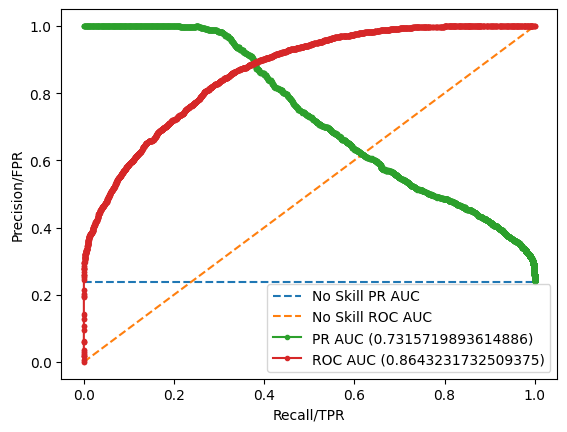

In [17]:
plot_valid_test(results.iloc[-1], Y_valid, Y_test)

In [21]:
results.iloc[-1].model.save_model("model.json")

In [22]:
important_columns[:5]

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss']

In [23]:
X[important_columns[:5]].to_csv("extracted_data.csv", index=False)